# Image features exercise
We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import os
os.chdir(os.getcwd() + '/..')

# Run some setup code for this notebook
import random
import numpy as np
import matplotlib.pyplot as plt

from utils.data_utils import load_CIFAR10

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from utils.data_utils import get_CIFAR10_data

cifar10_dir = 'datasets/cifar-10-batches-py'
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data(cifar10_dir, num_training=49000, num_validation=1000, num_test=1000)

print (X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

((49000, 32, 32, 3), (49000,), (1000, 32, 32, 3), (1000,), (1000, 32, 32, 3), (1000,))


## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, **HOG should capture the texture of the image while ignoring
color information**, and the **color histogram represents the color of the input
image while ignoring texture**. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for the bonus section.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [3]:
from utils.features_utils import extract_features, hog_feature, color_histogram_hsv

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation.
# This ensures that each feature has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones([X_train_feats.shape[0], 1])])
X_val_feats = np.hstack([X_val_feats, np.ones([X_val_feats.shape[0], 1])])
X_test_feats = np.hstack([X_test_feats, np.ones([X_test_feats.shape[0], 1])])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [4]:
# Use the validation set to tune the learning rate and regularization strength
# val accuracy should reach near 0.44

from classifiers.linear_classifier import LinearSVM

learning_rates = [1e-4, 3e-4, 9e-4, 1e-3, 3e-3, 9e-3, 1e-2, 3e-2, 9e-2, 1e-1]
regularization_strengths = [1e-1, 3e-1, 9e-1, 1, 3, 9]

# results[(learning_rate, reg)] = (train_accuracy, val_accuracy)
results = {}
best_val = -1
best_svm = None

for learning_rate in learning_rates:
    for reg in regularization_strengths:
        model = LinearSVM()
        model.train(X_train_feats, y_train, learning_rate=learning_rate, reg=reg, num_iters=5000,
                   batch_size=300, verbose=True)
        y_train_pred = model.predict(X_train_feats)
        train_accuracy = np.mean(y_train == y_train_pred)
        y_val_pred = model.predict(X_val_feats)
        val_accuracy = np.mean(y_val == y_val_pred)
        
        results[(learning_rate, reg)] = (train_accuracy, val_accuracy)
        if val_accuracy > best_val:
            best_val = val_accuracy
            best_svm = model
            
        print('lr %e reg %e train_accuracy: %f val_accuracy: %f' % (learning_rate, reg, train_accuracy, val_accuracy))
    print
    
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train_accuracy: %f val_accuracy: %f' % (lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 5000: loss 9.011121
iteration 100 / 5000: loss 8.322861
iteration 200 / 5000: loss 7.660865
iteration 300 / 5000: loss 7.051973
iteration 400 / 5000: loss 6.400993
iteration 500 / 5000: loss 5.951562
iteration 600 / 5000: loss 5.664219
iteration 700 / 5000: loss 5.181060
iteration 800 / 5000: loss 4.867892
iteration 900 / 5000: loss 5.361546
iteration 1000 / 5000: loss 4.646933
iteration 1100 / 5000: loss 5.065915
iteration 1200 / 5000: loss 4.581701
iteration 1300 / 5000: loss 4.595005
iteration 1400 / 5000: loss 4.524878
iteration 1500 / 5000: loss 4.588103
iteration 1600 / 5000: loss 4.277639
iteration 1700 / 5000: loss 4.535939
iteration 1800 / 5000: loss 4.643322
iteration 1900 / 5000: loss 4.470205
iteration 2000 / 5000: loss 4.352496
iteration 2100 / 5000: loss 4.076629
iteration 2200 / 5000: loss 4.208459
iteration 2300 / 5000: loss 4.198189
iteration 2400 / 5000: loss 4.140494
iteration 2500 / 5000: loss 3.574724
iteration 2600 / 5000: loss 4.060319
iteration 270

In [5]:
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train_accuracy: %f val_accuracy: %f' % (lr, reg, train_accuracy, val_accuracy))

lr 1.000000e-04 reg 1.000000e-01 train_accuracy: 0.482980 val_accuracy: 0.470000
lr 1.000000e-04 reg 3.000000e-01 train_accuracy: 0.480918 val_accuracy: 0.471000
lr 1.000000e-04 reg 9.000000e-01 train_accuracy: 0.476939 val_accuracy: 0.469000
lr 1.000000e-04 reg 1.000000e+00 train_accuracy: 0.476367 val_accuracy: 0.472000
lr 1.000000e-04 reg 3.000000e+00 train_accuracy: 0.463429 val_accuracy: 0.452000
lr 1.000000e-04 reg 9.000000e+00 train_accuracy: 0.432837 val_accuracy: 0.435000
lr 3.000000e-04 reg 1.000000e-01 train_accuracy: 0.500755 val_accuracy: 0.485000
lr 3.000000e-04 reg 3.000000e-01 train_accuracy: 0.495714 val_accuracy: 0.485000
lr 3.000000e-04 reg 9.000000e-01 train_accuracy: 0.485837 val_accuracy: 0.476000
lr 3.000000e-04 reg 1.000000e+00 train_accuracy: 0.483571 val_accuracy: 0.477000
lr 3.000000e-04 reg 3.000000e+00 train_accuracy: 0.463653 val_accuracy: 0.457000
lr 3.000000e-04 reg 9.000000e+00 train_accuracy: 0.433776 val_accuracy: 0.435000
lr 9.000000e-04 reg 1.000000

In [6]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.489000


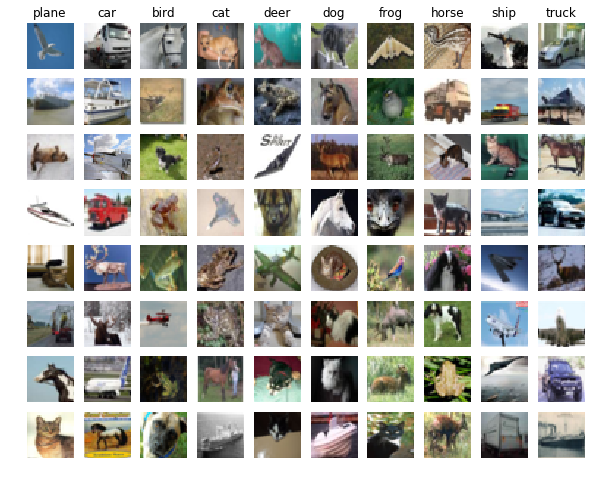

In [7]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
            
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?
**not obvious sense**

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [8]:
print(X_train_feats.shape)

(49000, 155)


In [22]:
from classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

learning_rates = [3e-1, 9e-1, 1]
regularization_strengths = [3e-3, 4e-3, 5e-3, 6e-3, 7e-3, 8e-3, 9e-3, 1e-2]

results = {}

best_model = None
best_val = -1

for lr in learning_rates:
    for reg in regularization_strengths:
        model = TwoLayerNet(input_dim, hidden_dim, num_classes, std=1e-1)
        stats = model.train(X_train_feats, y_train, X_val_feats, y_val,
                         learning_rate=lr, learning_rate_decay=0.95,
                          reg=reg, num_iters=5000, batch_size=200, verbose=True)

        train_acc = (model.predict(X_train_feats) == y_train).mean()
        val_acc = (model.predict(X_val_feats) == y_val).mean()
        print('lr: %e, reg: %e, train_acc: %f, val_acc: %f' % (lr, reg, train_acc, val_acc))

        results[(lr, reg)] = (train_acc, val_acc)
        if val_acc > best_val:
            best_val = val_acc
            best_model = model
print
     
print('best val_acc: %f' % (best_val))
    
old_lr = -1
for lr, reg in sorted(results):
    if old_lr != lr:
        old_lr = lr
        print
        
    train_acc, val_acc = results[(lr, reg)]
    print('lr: %e, reg: %e, train_acc: %f, val_acc: %f' % (lr, reg, train_acc, val_acc))

iteration 1 / 5000: loss 5.976893
iteration 101 / 5000: loss 3.176106
iteration 201 / 5000: loss 2.409488
iteration 301 / 5000: loss 2.191569
iteration 401 / 5000: loss 1.842398
iteration 501 / 5000: loss 1.844388
iteration 601 / 5000: loss 1.563744
iteration 701 / 5000: loss 1.605641
iteration 801 / 5000: loss 1.553624
iteration 901 / 5000: loss 1.399533
iteration 1001 / 5000: loss 1.343294
iteration 1101 / 5000: loss 1.312609
iteration 1201 / 5000: loss 1.338947
iteration 1301 / 5000: loss 1.336176
iteration 1401 / 5000: loss 1.384308
iteration 1501 / 5000: loss 1.358256
iteration 1601 / 5000: loss 1.393873
iteration 1701 / 5000: loss 1.275851
iteration 1801 / 5000: loss 1.271719
iteration 1901 / 5000: loss 1.446877
iteration 2001 / 5000: loss 1.340202
iteration 2101 / 5000: loss 1.263369
iteration 2201 / 5000: loss 1.347515
iteration 2301 / 5000: loss 1.301203
iteration 2401 / 5000: loss 1.300777
iteration 2501 / 5000: loss 1.158752
iteration 2601 / 5000: loss 1.310510
iteration 270

In [23]:
old_lr = -1
for lr, reg in sorted(results):
    if old_lr != lr:
        old_lr = lr
        print
        
    train_acc, val_acc = results[(lr, reg)]
    print('lr: %e, reg: %e, train_acc: %f, val_acc: %f' % (lr, reg, train_acc, val_acc))


lr: 3.000000e-01, reg: 3.000000e-03, train_acc: 0.653959, val_acc: 0.608000
lr: 3.000000e-01, reg: 4.000000e-03, train_acc: 0.621939, val_acc: 0.578000
lr: 3.000000e-01, reg: 5.000000e-03, train_acc: 0.601184, val_acc: 0.588000
lr: 3.000000e-01, reg: 6.000000e-03, train_acc: 0.580816, val_acc: 0.559000
lr: 3.000000e-01, reg: 7.000000e-03, train_acc: 0.569612, val_acc: 0.552000
lr: 3.000000e-01, reg: 8.000000e-03, train_acc: 0.554163, val_acc: 0.543000
lr: 3.000000e-01, reg: 9.000000e-03, train_acc: 0.548959, val_acc: 0.531000
lr: 3.000000e-01, reg: 1.000000e-02, train_acc: 0.539224, val_acc: 0.530000

lr: 9.000000e-01, reg: 3.000000e-03, train_acc: 0.635122, val_acc: 0.587000
lr: 9.000000e-01, reg: 4.000000e-03, train_acc: 0.602755, val_acc: 0.566000
lr: 9.000000e-01, reg: 5.000000e-03, train_acc: 0.586265, val_acc: 0.570000
lr: 9.000000e-01, reg: 6.000000e-03, train_acc: 0.571020, val_acc: 0.551000
lr: 9.000000e-01, reg: 7.000000e-03, train_acc: 0.553061, val_acc: 0.540000
lr: 9.0000

In [ ]:
# get more than 55% accuracy
test_acc = (best_model.predict(X_test_feats) == y_test).mean()
print('Test accuracy: ', test_acc)

# Bonus: Design your own features!

You have seen that simple image features can improve classification performance. So far we have tried HOG and color histograms, but other types of features may be able to achieve even better classification performance.

For bonus points, design and implement a new type of feature and use it for image classification on CIFAR-10. Explain how your feature works and why you expect it to be useful for image classification. Implement it in this notebook, cross-validate any hyperparameters, and compare its performance to the HOG + Color histogram baseline.

# Bonus: Do something extra!
Use the material and code we have presented in this assignment to do something interesting. Was there another question we should have asked? Did any cool ideas pop into your head as you were working on the assignment? This is your chance to show off!